In [1]:
#Data manipulation and preprocessing 
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
#Data exploration
from sklearn.feature_selection import chi2
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
#Data balancing
from imblearn.over_sampling import SMOTE
#Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
#Model Evaluation
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report,accuracy_score,roc_curve
import warnings
warnings.filterwarnings("ignore")

### Data preprocessing

In [2]:
data = pd.read_csv("urinalysis_tests.csv")#importing the dataset
data.head()

,Unnamed: 0,Age,Gender,Color,Transparency,Glucose,Protein,pH,Specific Gravity,WBC,RBC,Epithelial Cells,Mucous Threads,Amorphous Urates,Bacteria,Diagnosis
0,0,76.0,FEMALE,LIGHT YELLOW,CLEAR,NEGATIVE,NEGATIVE,5.0,1.010,1-3,0-2,OCCASIONAL,RARE,NONE SEEN,OCCASIONAL,NEGATIVE
1,1,9.0,MALE,DARK YELLOW,SLIGHTLY HAZY,NEGATIVE,1+,5.0,1.030,1-3,0-2,RARE,FEW,FEW,MODERATE,NEGATIVE
2,2,12.0,MALE,LIGHT YELLOW,SLIGHTLY HAZY,NEGATIVE,TRACE,5.0,1.030,0-3,0-2,RARE,FEW,MODERATE,RARE,NEGATIVE
3,3,77.0,MALE,BROWN,CLOUDY,NEGATIVE,1+,6.0,1.020,5-8,LOADED,RARE,RARE,NONE SEEN,FEW,NEGATIVE
4,4,29.0,FEMALE,YELLOW,HAZY,NEGATIVE,TRACE,6.0,1.025,1-4,0-2,RARE,RARE,NONE SEEN,FEW,NEGATIVE


In [3]:
data.drop(columns = "Unnamed: 0", axis = 1,inplace = True)#removing the unnamed column
data.head()

,Age,Gender,Color,Transparency,Glucose,Protein,pH,Specific Gravity,WBC,RBC,Epithelial Cells,Mucous Threads,Amorphous Urates,Bacteria,Diagnosis
0,76.0,FEMALE,LIGHT YELLOW,CLEAR,NEGATIVE,NEGATIVE,5.0,1.010,1-3,0-2,OCCASIONAL,RARE,NONE SEEN,OCCASIONAL,NEGATIVE
1,9.0,MALE,DARK YELLOW,SLIGHTLY HAZY,NEGATIVE,1+,5.0,1.030,1-3,0-2,RARE,FEW,FEW,MODERATE,NEGATIVE
2,12.0,MALE,LIGHT YELLOW,SLIGHTLY HAZY,NEGATIVE,TRACE,5.0,1.030,0-3,0-2,RARE,FEW,MODERATE,RARE,NEGATIVE
3,77.0,MALE,BROWN,CLOUDY,NEGATIVE,1+,6.0,1.020,5-8,LOADED,RARE,RARE,NONE SEEN,FEW,NEGATIVE
4,29.0,FEMALE,YELLOW,HAZY,NEGATIVE,TRACE,6.0,1.025,1-4,0-2,RARE,RARE,NONE SEEN,FEW,NEGATIVE


In [4]:
data.shape #size of the dataset

(1436, 15)

In [5]:
data['Diagnosis'].value_counts() #values in the diagnosis

Diagnosis
NEGATIVE    1355
POSITIVE      81
Name: count, dtype: int64

Text(0.5, 1.0, 'Negative versus positive diagnosis')

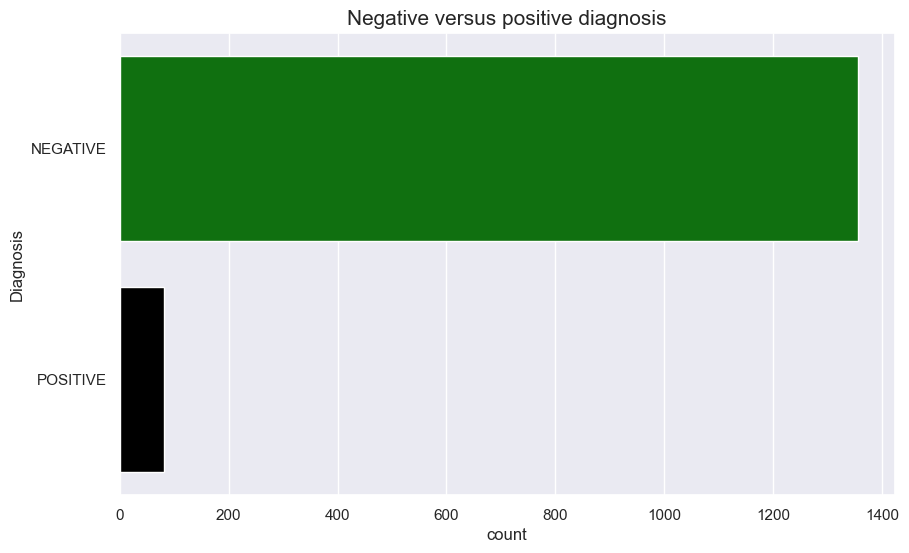

In [6]:
#Negative and positive diagnosis
plt.figure(figsize = (10,6))
sns.countplot(data['Diagnosis'], palette=['green', 'black'])
plt.title('Negative versus positive diagnosis',fontdict = {'size':15})

Text(0.5, 1.0, 'Percentage of female UTI patients among the female population')

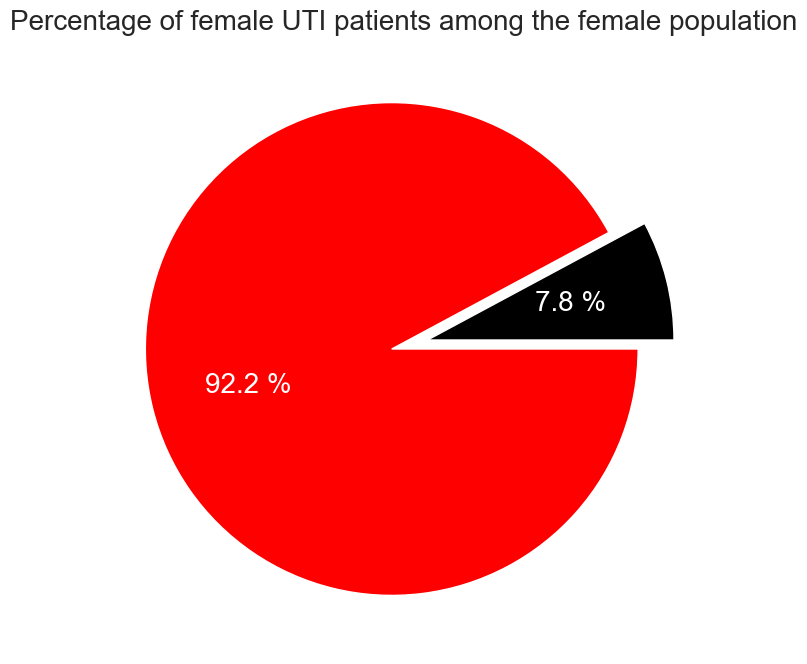

In [7]:
positive_diag = data[data['Diagnosis']=="POSITIVE"] #positive diagnosis subset
#percentage of female uti patients among the female population
perc_fem = len(positive_diag[positive_diag["Gender"]=='FEMALE'])/len(data[data["Gender"]=='FEMALE'])
plt.figure(figsize = (8,8)) #size of the pie chart
plt.pie([perc_fem,1-perc_fem],
        explode =[0.1,0.05],
        colors = ['black','red'],
       autopct = "%2.1f %%",
        textprops={"color":"white",
                   "size" : 20}
       )#pie plot showing results
plt.title("Percentage of female UTI patients among the female population",
         fontdict = {"size":20}) #title of the chart and its size

## Data Preprocessing

In [8]:
#Missing data analysis
data.isnull().sum()

Age                 0
Gender              0
Color               1
Transparency        0
Glucose             0
Protein             0
pH                  0
Specific Gravity    0
WBC                 0
RBC                 0
Epithelial Cells    0
Mucous Threads      0
Amorphous Urates    0
Bacteria            0
Diagnosis           0
dtype: int64

In [9]:
#Drop missing data rows
data.dropna(inplace = True)
data.isnull().sum()

Age                 0
Gender              0
Color               0
Transparency        0
Glucose             0
Protein             0
pH                  0
Specific Gravity    0
WBC                 0
RBC                 0
Epithelial Cells    0
Mucous Threads      0
Amorphous Urates    0
Bacteria            0
Diagnosis           0
dtype: int64

In [10]:
#convert categorical data to numerical data
cat_data = data[['Gender', 'Color', 'Transparency', 'Glucose', 'Protein', 'pH',
       'Specific Gravity', 'WBC', 'RBC', 'Epithelial Cells', 'Mucous Threads',
       'Amorphous Urates', 'Bacteria', 'Diagnosis']]
LB = LabelEncoder()
cat_data = cat_data.apply(LB.fit_transform)

In [11]:
#Chi-square for correlation in the categorical data
correlation = pd.DataFrame(data=[(0 for i in range(len(cat_data.columns))) for i in range(len(cat_data.columns))], 
                         columns=list(cat_data.columns))
correlation.set_index(pd.Index(list(cat_data.columns)), inplace = True)

# Finding p_value for all columns and putting them in the resultant matrix
for i in list(cat_data.columns):
    for j in list(cat_data.columns):
        if i != j:
            chi2_val, p_val = chi2(np.array(cat_data[i].astype("float64")).reshape(-1, 1),
                                   np.array(cat_data[j].astype("float64")).reshape(-1, 1))
            correlation.loc[i,j] = p_val


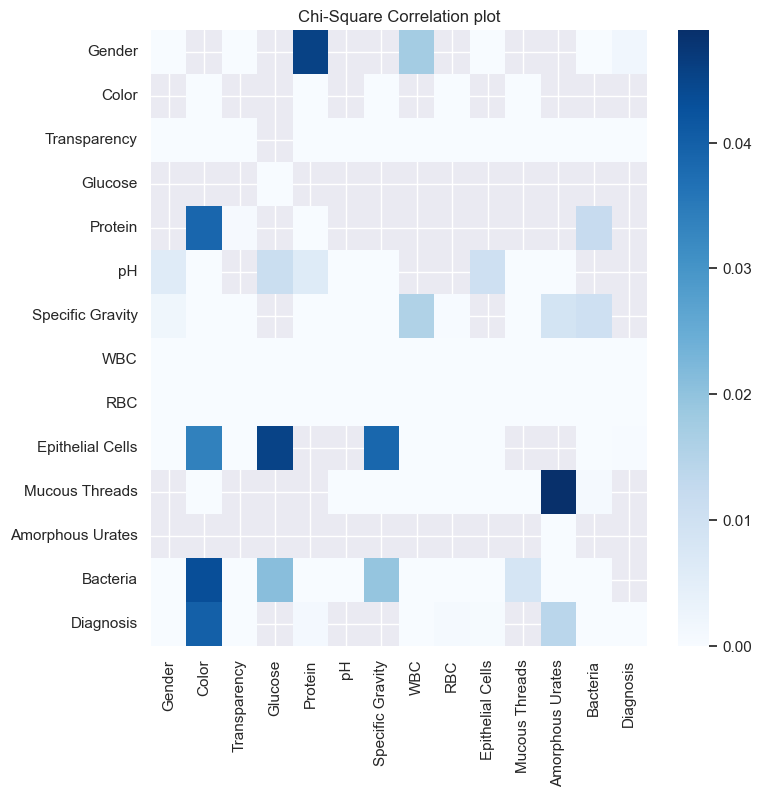

In [12]:
# Plotting a heatmap
plt.figure(figsize=(8,8))
sns.heatmap(correlation[correlation<0.05], cmap='Blues')
plt.title('Chi-Square Correlation plot')
plt.show()

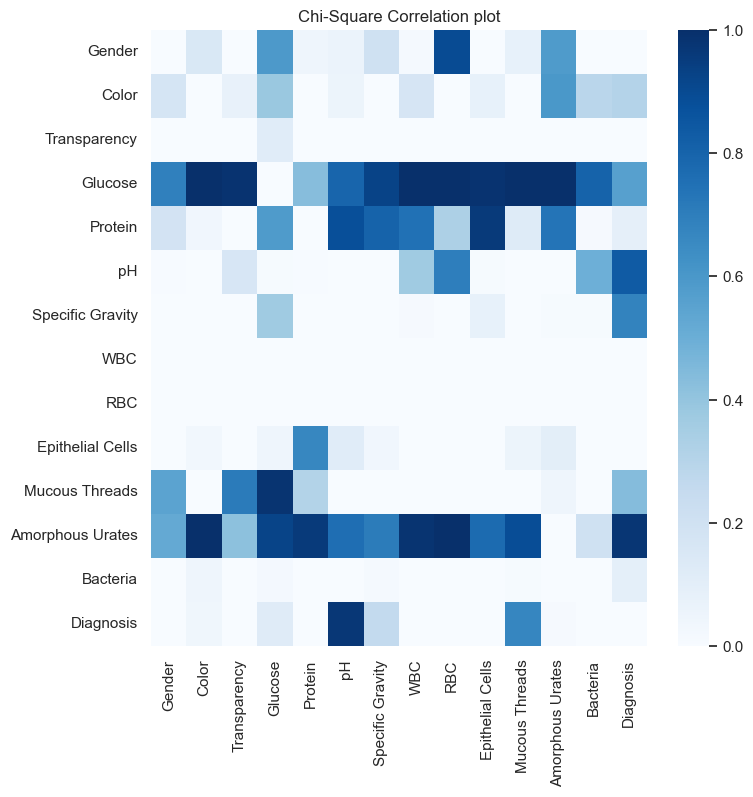

In [13]:
# Plotting a heatmap
plt.figure(figsize=(8,8))
sns.heatmap(correlation, cmap='Blues')
plt.title('Chi-Square Correlation plot')
plt.show()

In [14]:
data.columns

Index(['Age', 'Gender', 'Color', 'Transparency', 'Glucose', 'Protein', 'pH',
       'Specific Gravity', 'WBC', 'RBC', 'Epithelial Cells', 'Mucous Threads',
       'Amorphous Urates', 'Bacteria', 'Diagnosis'],
      dtype='object')

In [15]:
for col in cat_data.columns: #categorical data and what each label encoded represents
    print(data[col].unique())
    print(cat_data[col].unique())

['FEMALE' 'MALE']
[0 1]
['LIGHT YELLOW' 'DARK YELLOW' 'BROWN' 'YELLOW' 'AMBER' 'STRAW' 'RED'
 'REDDISH' 'REDDISH YELLOW' 'LIGHT RED']
[4 2 1 9 0 8 5 6 7 3]
['CLEAR' 'SLIGHTLY HAZY' 'CLOUDY' 'HAZY' 'TURBID']
[0 3 1 2 4]
['NEGATIVE' '3+' '1+' 'TRACE' '4+' '2+']
[4 2 0 5 3 1]
['NEGATIVE' '1+' 'TRACE' '2+' '3+']
[3 0 4 1 2]
[5.  6.  7.  7.5 6.5 8. ]
[0 1 3 4 2 5]
[1.01  1.03  1.02  1.025 1.005 1.015]
[1 5 3 4 0 2]
['1-3' '0-3' '5-8' '1-4' '3-5' '70-75' '0-2' '1-2' '2-4' '6-8' '8-10'
 '10-12' '0-1' '4-6' '20-25' '25-30' '18-25' '3-6' 'LOADED' '28-30' '5-7'
 '12-15' '15-17' '30-35' '8-12' '2-3' '35-40' '50-55' '11-15' '48-55'
 '45-50' '12-14' '14-16' '17-20' '55-58' '9-11' '>50' '15-20' '20-22'
 '18-20' '7-9' 'TNTC' '2-5' '34-36' '30-32' '23-25' '5-10' '9-15' '13-15'
 '4-8' '11-14' '10-16' '7-15' '7-8' '0-4' '15-22' '15-21' '>100' '7-10'
 '15-28' '1-5' '4-5' '2-7' '3-7' '10-15' '4-7' '79-85' '28-35' '3-10'
 '5-6' '3-4' '15-18' '4-10' '10-18' '8-11']
[ 5  2 56  6 39 64  1  4 28 59 66  8  0 48

In [16]:
#Feature selection and data splitting
x = pd.concat([cat_data,data['Age']],axis = 1)
y = cat_data['Diagnosis']
len(y)

1435

In [17]:
x.head()

,Gender,Color,Transparency,Glucose,Protein,pH,Specific Gravity,WBC,RBC,Epithelial Cells,Mucous Threads,Amorphous Urates,Bacteria,Diagnosis,Age
0,0,4,0,4,3,0,1,5,2,4,5,2,3,0,76.0
1,1,2,3,4,0,0,5,5,2,6,0,0,2,0,9.0
2,1,4,3,4,4,0,5,2,2,6,0,1,5,0,12.0
3,1,1,1,4,0,1,3,56,51,6,5,2,0,0,77.0
4,0,9,2,4,4,1,4,6,2,6,5,2,0,0,29.0


In [18]:
cat_data.isnull().sum()

Gender              0
Color               0
Transparency        0
Glucose             0
Protein             0
pH                  0
Specific Gravity    0
WBC                 0
RBC                 0
Epithelial Cells    0
Mucous Threads      0
Amorphous Urates    0
Bacteria            0
Diagnosis           0
dtype: int64

### Data splitting

In [19]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3, random_state = 40)
print(len(x_train))
print(len(x_test))

1004
431


### Training the imbalanced data

In [51]:
class TrainImbModels:
    def __init__(self,model,x_train, y_train, x_test, y_test):
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.predictions = None
    def imb_model(self):#function for training imbalanced models
        self.model.fit(self.x_train,self.y_train)
        self.predictions = self.model.predict(x_test)
        return print(classification_report(self.y_test,self.predictions))
    def plot_roc(self,title):
        self.title = title
        plt.title(self.title)
        plt.plot(roc_curve(self.y_test,self.predictions))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - {model_name}')

In [43]:
k_nn = TrainImbModels(KNeighborsClassifier(),RandomForestClassifier,x_train, y_train, x_test, y_test)
k_nn.imb_model()

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       414
           1       0.00      0.00      0.00        17

    accuracy                           0.96       431
   macro avg       0.48      0.50      0.49       431
weighted avg       0.92      0.96      0.94       431



In [53]:
Rand_for = TrainImbModels(RandomForestClassifier(),x_train, y_train, x_test, y_test)
Rand_for.imb_model()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       414
           1       1.00      1.00      1.00        17

    accuracy                           1.00       431
   macro avg       1.00      1.00      1.00       431
weighted avg       1.00      1.00      1.00       431



In [54]:
Log_reg = TrainImbModels(LogisticRegression(),x_train, y_train, x_test, y_test)
Log_reg.imb_model()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       414
           1       1.00      1.00      1.00        17

    accuracy                           1.00       431
   macro avg       1.00      1.00      1.00       431
weighted avg       1.00      1.00      1.00       431



In [59]:
lr = RandomForestClassifier()
lr.fit(x_train,y_train)
pred = lr.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       414
           1       1.00      1.00      1.00        17

    accuracy                           1.00       431
   macro avg       1.00      1.00      1.00       431
weighted avg       1.00      1.00      1.00       431



In [60]:
cf = confusion_matrix(y_test,pred)
cf

array([[414,   0],
       [  0,  17]], dtype=int64)

In [52]:
k_nn.plot_roc("ROC curve for KNN imbalanced model")

TypeError: TrainImbModels.plot_roc() takes 1 positional argument but 2 were given

### Data balancing

In [45]:
smote = SMOTE()
x_train_bal, y_train_bal = smote.fit_transform(x_train, y_train)

AttributeError: 'SMOTE' object has no attribute 'fit_transform'

### Training the models with balanced data

In [ ]:
class TrainBalModels:
    def __init__(self,model,x_train, y_train, x_test, y_test):
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.predictions = None
    def imb_model(self):#function for training imbalanced models
        self.model.fit(self.x_train,self.y_train)
        self.predictions = self.model.predict(x_test)
        return print(classification_report(self.y_test,self.predictions))
    def plot_roc(self):
        plt.plot(roc_curve(self.y_test,self.predictions))